In [1]:
# ==============================
# Churn Prediction + SHAP Analysis
# ==============================

# 1️⃣ Setup
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from xgboost import XGBClassifier



In [2]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Create outputs folder
OUTPUT_DIR = '/content/drive/MyDrive/data/outputs'
SHAP_DIR = os.path.join(OUTPUT_DIR,"shap_plots")
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(SHAP_DIR, exist_ok=True)

DATA_PATH = '/content/drive/MyDrive/data/telecom_churn.csv'
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}")


In [4]:
# ==============================
# 2️⃣ Load Dataset
# ==============================
df = pd.read_csv(DATA_PATH)
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# ==============================
# 3️⃣ Preprocessing
# ==============================
# Convert Yes/No to 1/0
for col in df.select_dtypes(include='object').columns:
    if set(df[col].dropna().str.lower().unique()) <= {'yes','no'}:
        df[col] = df[col].map({'Yes':1,'No':0,'yes':1,'no':0})


In [6]:
# Separate target
target_col = [c for c in df.columns if 'churn' in c.lower()][0]
y = df[target_col].astype(int)
X = df.drop(columns=[target_col])


In [7]:
# One-hot encode remaining categorical
obj_cols = X.select_dtypes(include='object').columns
if len(obj_cols) > 0:
    X = pd.get_dummies(X, columns=obj_cols, drop_first=True)


In [8]:
# Replace inf/nan and impute
X = X.replace([np.inf, -np.inf], np.nan)
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


In [9]:
# Scale numeric features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [11]:
# Save preprocessed data
joblib.dump((X_train, X_test, y_train, y_test), os.path.join(OUTPUT_DIR,"split_data.pkl"))
joblib.dump(scaler, os.path.join(OUTPUT_DIR,"scaler.pkl"))

print("Preprocessing complete. Data ready for training.")


Preprocessing complete. Data ready for training.


In [21]:
# ==============================
# 4️⃣ Train XGBoost Model
# ==============================
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
)

In [22]:
from sklearn.model_selection import GridSearchCV
import joblib
import os

# Define parameter grid
param_grid = {
    "n_estimators": [150, 250],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0]
}


In [23]:
# GridSearchCV with live progress and parallel processing
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2,   # show progress for each combination and fold
    n_jobs=-1    # use all CPU cores
)

In [24]:
# Fit GridSearchCV
grid.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:49:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [150, 250], 'subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=2)

In [25]:
# Best model
best_model = grid.best_estimator_
print(f"✅ Best parameters: {grid.best_params_}")
print(f"✅ CV Best AUC: {grid.best_score_:.4f}")

✅ Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
✅ CV Best AUC: 0.8491


In [26]:
# Save model
os.makedirs(OUTPUT_DIR, exist_ok=True)
joblib.dump(best_model, os.path.join(OUTPUT_DIR,"xgb_model.joblib"))
print("✅ Model trained and saved.")


✅ Model trained and saved.


In [27]:
# ==============================
# 5️⃣ Evaluate Model
# ==============================
preds = best_model.predict(X_test)
preds_prob = best_model.predict_proba(X_test)[:,1]

metrics = {
    "AUC": roc_auc_score(y_test, preds_prob),
    "F1": f1_score(y_test, preds),
    "Accuracy": accuracy_score(y_test, preds),
    "Precision": precision_score(y_test, preds),
    "Recall": recall_score(y_test, preds)
}

df_metrics = pd.DataFrame([metrics])
df_metrics.to_csv(os.path.join(OUTPUT_DIR,"metrics.csv"), index=False)
print(df_metrics)

        AUC        F1  Accuracy  Precision    Recall
0  0.847679  0.575574  0.800681   0.661111  0.509636


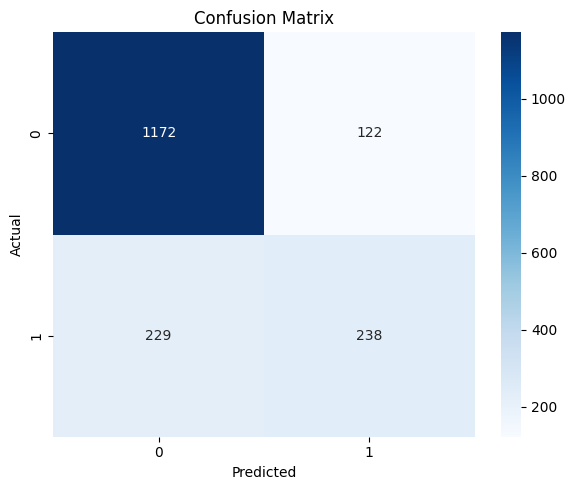

In [28]:
# Confusion matrix
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,"confusion_matrix.png"))
plt.show()

In [29]:
# ==============================
# 6️⃣ SHAP Analysis
# ==============================
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

In [30]:
# Global summary plot
plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR,"feature_importance.png"))
plt.close()
print("Global SHAP summary plot saved.")

Global SHAP summary plot saved.


In [31]:
# Local SHAP plots: 3 misclassified customers
wrong = np.where(preds != y_test)[0][:3]
if len(wrong)<3:
    wrong = np.arange(min(3,len(X_test)))

for i, idx in enumerate(wrong,1):
    shap.plots._waterfall.waterfall_legacy(
        explainer.expected_value, shap_values[idx], feature_names=X_test.columns, max_display=12, show=False
    )
    plt.tight_layout()
    plt.savefig(os.path.join(SHAP_DIR,f"customer_{i}.png"))
    plt.close()

In [32]:
# Dependence plots for top 3 features
mean_abs = np.abs(shap_values).mean(0)
top_idx = np.argsort(mean_abs)[::-1][:3]
top_features = [X_test.columns[i] for i in top_idx]

for feat in top_features:
    shap.dependence_plot(feat, shap_values, X_test, show=False)
    plt.tight_layout()
    plt.savefig(os.path.join(SHAP_DIR,f"dependence_{feat}.png"))
    plt.close()

print("SHAP analysis complete. All plots saved in 'outputs/shap_plots/'")


SHAP analysis complete. All plots saved in 'outputs/shap_plots/'
